In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib
import copy
import itertools

## Configuration
### Input files and FE algorithms to be studied
200PU electrons and pure 200PU events are loaded

In [4]:
version = '210430'
fig_dir = '../img/electron_pu_autoencoder_{}'.format(version)
algo_files = {}
# Read signal driven files
directory_elec = '/home/llr/cms/sauvan/DATA_UPG/HGCAL/Dataframes/study_autoencoder/3_22_1/electron_photon_signaldriven/v_1_2021-05-25'
directory_pu = '/home/llr/cms/sauvan/DATA_UPG/HGCAL/Dataframes/study_autoencoder/3_22_1/pu_for_id_signaldriven/v_1_2021-05-26'
fes = ['Threshold0', 'Threshold', 'Mixedbcstc',
       'AutoEncoderTelescopeMSE', 'AutoEncoderStride',
       'AutoEncoderQKerasTTbar', 'AutoEncoderQKerasEle',]
for fe in fes:
    algo_files[fe] = (glob(directory_elec+'/electrons/*.hdf5'), glob(directory_pu+'/*.hdf5'))


## Loading and preprocessing dataframes
Selection cuts (in addition to those already applied before):
- Gen electron $p_T > 5 GeV$
- Extrapolated gen electron eta between 1.6 and 2.9

Additionally label electrons and positrons as `1` and PU clusters as `0`

In [5]:
ptcut=15
etamin=1.6
etamax=2.9
algos_dfs = {}

for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        df = store[name]
        store.close()
        sel = df['genpart_pt']>ptcut
        df = df[sel]
        sel = np.abs(df['genpart_exeta'])>etamin
        df = df[sel]
        sel = np.abs(df['genpart_exeta'])<etamax
        df = df[sel]
        sel = df['matches']==True
        df = df[sel]
        df['genpart_pid'].replace([-11,11],1, inplace=True)
        dfs.append(df)
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        df = store[fe]
        store.close()
        df['genpart_pid'] = 0
        dfs.append(df)
    algos_dfs[fe] = pd.concat(dfs).reset_index()


In [6]:
for name,df in algos_dfs.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

In [7]:
df

,event,genpart_pid,genpart_exphi,genpart_exeta,genpart_gen,genpart_reachedEE,genpart_pt,genpart_energy,cl3d_pt,cl3d_eta,...,cl3d_layer_pt,deta,dphi,deltar,best_match,matches,cl3d_abseta,cl3d_pt_calib,cl3d_bdt_corr,cl3d_pt_corr
0,22243,1,1.208269,-2.867160,2.0,2.0,137.341660,1213.944214,75.986473,-2.874426,...,"[0.0, 0.240867018699646, 3.715573310852051, 8....",-0.007267,0.002783,0.007781,True,True,2.874426,NaN,NaN,NaN
1,22243,1,-1.936246,2.871025,1.0,2.0,137.341660,1213.944214,77.330177,2.876282,...,"[0.0, 0.202926367521286, 3.5369997024536133, 8...",0.005257,0.003904,0.006548,True,True,2.876282,NaN,NaN,NaN
2,22246,1,-0.399830,-2.644384,1.0,2.0,135.105331,970.571289,77.495438,-2.650998,...,"[0.0, 0.4379076361656189, 4.407777309417725, 9...",-0.006613,0.004403,0.007945,True,True,2.650998,NaN,NaN,NaN
3,22246,1,2.745551,2.676070,2.0,2.0,135.105331,970.571289,76.503006,2.677195,...,"[0.0, 0.3612406551837921, 3.9968667030334473, ...",0.001125,0.004338,0.004481,True,True,2.677195,NaN,NaN,NaN
4,22247,1,2.092056,2.137375,1.0,2.0,187.004105,808.856689,109.370377,2.134115,...,"[0.0, 0.1173502653837204, 1.9557416439056396, ...",-0.003260,0.000128,0.003263,True,True,2.134115,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217752,353630,0,NaN,NaN,NaN,NaN,NaN,NaN,7.503365,1.604450,...,"[0.0, 0.15280452370643616, 1.3352428674697876,...",NaN,NaN,NaN,NaN,NaN,1.604450,14.671590,5.562870,20.234460
217753,353629,0,NaN,NaN,NaN,NaN,NaN,NaN,21.773260,-1.674571,...,"[0.0, 0.04489101469516754, 0.06624197214841843...",NaN,NaN,NaN,NaN,NaN,1.674571,18.366300,4.596828,22.963128
217754,338798,0,NaN,NaN,NaN,NaN,NaN,NaN,12.628032,2.225179,...,"[0.0, 0.13748587667942047, 1.1524516344070435,...",NaN,NaN,NaN,NaN,NaN,2.225179,23.964349,-2.988831,20.975518
217755,338818,0,NaN,NaN,NaN,NaN,NaN,NaN,17.584526,2.189893,...,"[0.0, 0.10197335481643677, 1.3254179954528809,...",NaN,NaN,NaN,NaN,NaN,2.189893,30.897383,-2.502708,28.394674


## XGBOOST trainings

### Define stopping criteria, learning rate adapter and xgboost callbacks
The stopping criteria and learning rate adapter are actually dummy ones here, but could be changed.

The callback can store evaluation results for each boosting step, as well as check the stopping criteria and adapt the learning rate according to the learning rate adapter function

In [8]:
import json

class MyStopper():
    def __init__(self):
        self.eval_history = []
        
    def stop(self, eval_v):
        return False

def my_adapter(lr):
    return lr

class MyCallback():
    def __init__(self, stopper, lr_adapter):
        self.eval_values = {}
        self.stopper = stopper
        self.lr_adapter = lr_adapter

    def learning_rate(self, env):
        # No direct access to Booster params
        # The only way is to get the config as a json string. Not super nice.
        json_dict = json.loads(env.model.save_config())
        train_params = json_dict['learner']['gradient_booster']['updater']['grow_colmaker']['train_param']
        return float(train_params['learning_rate'])

    def callback(self, env):
        # Store all evaluation results
        for name, value in env.evaluation_result_list:
            if not name in self.eval_values:
                self.eval_values[name] = []
            self.eval_values[name].append(value)

        # Early stopping based on the last eval metrics in the test sample
        eval_v = env.evaluation_result_list[-1][1]
        #early stopping
        from xgboost.core import EarlyStopException
        if self.stopper!=None: 
            stopping = self.stopper.stop(eval_v)
            if stopping:
                print("Early stopping at epoch %d"%(env.iteration))
                # Should we store the best iteration? Current iteration is not necessarily the best
                raise EarlyStopException(env.iteration)

        #update the learning rate 
        if self.lr_adapter!=None:
            bst, i, n = env.model, env.iteration, env.end_iteration
            lr = self.learning_rate(env)
            new_lr = self.lr_adapter(lr)
            env.model.set_param('learning_rate', new_lr)

        completion=100*float(env.iteration+1)/float(env.end_iteration)


### Define default training parameters


In [9]:
params0 = {}
params0['nthread'] = 5  # limit number of threads to 5
params0['learning_rate'] = 0.05 # initial learning rate
params0['max_depth'] = 3  # maximum depth of a tree
params0['subsample'] = 0.8 # fraction of events to train tree on
params0['colsample_bytree'] = 0.8 # fraction of features to train tree on
params0['n_estimators'] = 100
params0['alpha'] = 10 # L1 regularization
params0['lambda'] = 10 # L2 regularization
#param['silent'] = True

# Learning task parameters
params0['objective'] = 'binary:logistic'

inputs = ['cl3d_abseta','cl3d_showerlength',
    'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
    'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean',
    'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10',
    'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90',
]
output = 'genpart_pid'

### Training with different L1 and L2 regularization parameters

In [10]:

trained_models_reg = {}
stoppers_reg = {}
callbacks_reg = {}
params_reg = {}
# Turn to True in order to train for all the different FE algorithms
run_all_reg = False

# Will scan these L1 and L2 regularization values
l1s = [0, 0.5, 1, 5, 10, 20]
l2s = [0, 0.5, 1, 5, 10, 20]


for name, df in algos_dfs.items():
    if not run_all_reg and name!='Threshold0':
        continue
    print('==========================================')
    print('Trainings for', name)
    X_train, X_test, y_train, y_test = train_test_split(df[inputs], df[output], test_size=0.2, random_state=1234)
    weight_elec_train = y_train[y_train==0].shape[0]/y_train[y_train==1].shape[0]
    weight_elec_test = y_test[y_test==0].shape[0]/y_test[y_test==1].shape[0]
    print(" Electron size, train:", y_train[y_train==1].shape[0], "test:", y_test[y_test==1].shape[0])
    print(" PU size, train:", y_train[y_train==0].shape[0], "test:", y_test[y_test==0].shape[0])
    print(" Applying weight of", weight_elec_train, "to electrons to balance the training sample")
    print(" Applying weight of", weight_elec_test, "to electrons to balance the testing sample")
    print('==========================================')
    w_train = np.where(y_train==1, weight_elec_train, 1.)
    w_test = np.where(y_test==1, weight_elec_test, 1.)
    trained_models_reg[name] = []
    stoppers_reg[name] = []
    callbacks_reg[name] = []
    params_reg[name] = []
    for l1,l2 in itertools.product(l1s, l2s):
        print(' > Training L1=', l1, 'L2=', l2)
        param_cp = copy.deepcopy(params0)
        param_cp['alpha'] = l1
        param_cp['lambda'] = l2
        my_stopper = MyStopper()
        my_callback = MyCallback(my_stopper, my_adapter)
        model = xgb.XGBClassifier()
        model.set_params(**param_cp)
        trained_model = model.fit(X_train, y_train, 
                    sample_weight=w_train,
                    verbose=False, callbacks=[my_callback.callback],
                    eval_set=[(X_train,y_train), (X_test, y_test)], # 0=train, 1=test
                    sample_weight_eval_set=[w_train, w_test],
                    eval_metric=['auc','logloss'])
        params_reg[name].append(param_cp)
        trained_models_reg[name].append(trained_model)
        stoppers_reg[name].append(my_stopper)
        callbacks_reg[name].append(my_callback)

Trainings for Threshold0
 Electron size, train: 170962 test: 42749
 PU size, train: 4828 test: 1199
 Applying weight of 0.02824019372726103 to electrons to balance the training sample
 Applying weight of 0.028047439706191956 to electrons to balance the testing sample
 > Training L1= 0 L2= 0
 > Training L1= 0 L2= 0.5
 > Training L1= 0 L2= 1
 > Training L1= 0 L2= 5
 > Training L1= 0 L2= 10
 > Training L1= 0 L2= 20
 > Training L1= 0.5 L2= 0
 > Training L1= 0.5 L2= 0.5
 > Training L1= 0.5 L2= 1
 > Training L1= 0.5 L2= 5
 > Training L1= 0.5 L2= 10
 > Training L1= 0.5 L2= 20
 > Training L1= 1 L2= 0
 > Training L1= 1 L2= 0.5
 > Training L1= 1 L2= 1
 > Training L1= 1 L2= 5
 > Training L1= 1 L2= 10
 > Training L1= 1 L2= 20
 > Training L1= 5 L2= 0
 > Training L1= 5 L2= 0.5
 > Training L1= 5 L2= 1
 > Training L1= 5 L2= 5
 > Training L1= 5 L2= 10
 > Training L1= 5 L2= 20
 > Training L1= 10 L2= 0
 > Training L1= 10 L2= 0.5
 > Training L1= 10 L2= 1
 > Training L1= 10 L2= 5
 > Training L1= 10 L2= 10


For each (L1, L2) pair, extract the maximum AUC on the test sample, and get the AUC on the train sample corresponding to this maximum test AUC.

In [11]:
l1l2s = {}
test_auc_max_reg = {}
train_auc_max_reg = {}
for name in params_reg.keys():
    if not run_all_reg and name!='Threshold0':
        continue
    l1l2s[name] = []
    test_auc_max_reg[name] = []
    train_auc_max_reg[name] = []
    for param,callback in zip(params_reg[name],callbacks_reg[name]):
        l1l2s[name].append(l1s.index(param['alpha'])*len(l2s)+ l2s.index(param['lambda']))
        # Extract the argmax on the test set and get the corresponding AUC in the validation and test sets
        amax_auc = np.argmax(callback.eval_values['validation_1-auc'])
        test_auc_max_reg[name].append(callback.eval_values['validation_1-auc'][amax_auc])
        train_auc_max_reg[name].append(callback.eval_values['validation_0-auc'][amax_auc])

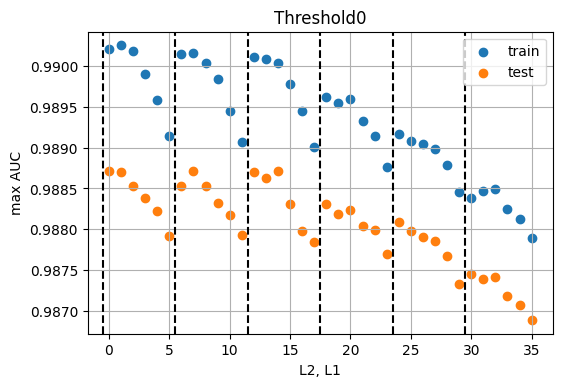

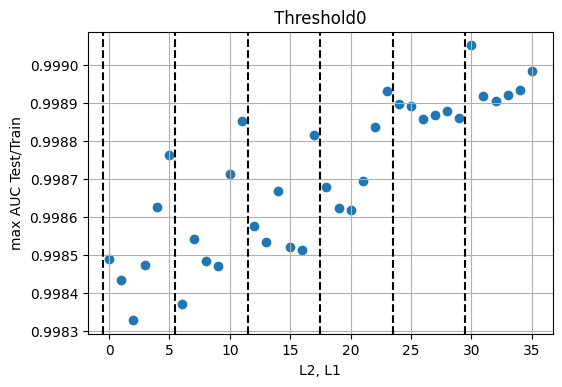

In [12]:
for name in l1l2s.keys():
    plt.figure(dpi=100)
    plt.scatter(l1l2s[name], train_auc_max_reg[name], label='train')
    plt.scatter(l1l2s[name], test_auc_max_reg[name], label='test')
    plt.grid()
    plt.ylabel('max AUC')
    plt.xlabel('L2, L1')
    plt.legend()
    plt.title(name)
    for i in range(len(l1s)):
        plt.axvline(x = i*len(l2s)-0.5, color = 'black', ls='--') 
    plt.show()
    #
    plt.figure(dpi=100)
    plt.scatter(l1l2s[name], np.array(test_auc_max_reg[name])/np.array(train_auc_max_reg[name]))
    plt.grid()
    plt.ylabel('max AUC Test/Train')
    plt.xlabel('L2, L1')
    plt.title(name)
    for i in range(len(l1s)):
        plt.axvline(x = i*len(l2s)-0.5, color = 'black', ls='--')
    plt.show()

### Training with different learning rates

In [13]:

trained_models_lr = {}
stoppers_lr = {}
callbacks_lr = {}
params_lr = {}
# Turn to True in order to train for all the different FE algorithms
run_all_lr = False

# Learning rate values to be scanned
lrs = [0.3, 0.2, 0.1, 0.05, 0.03, 0.02, 0.01]


for name, df in algos_dfs.items():
    if not run_all_lr and name!='Threshold0':
        continue
    print('==========================================')
    print('Trainings for', name)
    X_train, X_test, y_train, y_test = train_test_split(df[inputs], df[output], test_size=0.2, random_state=1234)
    weight_elec_train = y_train[y_train==0].shape[0]/y_train[y_train==1].shape[0]
    weight_elec_test = y_test[y_test==0].shape[0]/y_test[y_test==1].shape[0]
    print(" Electron size, train:", y_train[y_train==1].shape[0], "test:", y_test[y_test==1].shape[0])
    print(" PU size, train:", y_train[y_train==0].shape[0], "test:", y_test[y_test==0].shape[0])
    print(" Applying weight of", weight_elec_train, "to electrons to balance the training sample")
    print(" Applying weight of", weight_elec_test, "to electrons to balance the testing sample")
    print('==========================================')
    w_train = np.where(y_train==1, weight_elec_train, 1.)
    w_test = np.where(y_test==1, weight_elec_test, 1.)
    trained_models_lr[name] = []
    stoppers_lr[name] = []
    callbacks_lr[name] = []
    params_lr[name] = []
    for lr in lrs:
        print(' > Training lr=', lr)
        param_cp = copy.deepcopy(params0)
        param_cp['learning_rate'] = lr
        my_stopper = MyStopper()
        my_callback = MyCallback(my_stopper, my_adapter)
        model = xgb.XGBClassifier()
        model.set_params(**param_cp)
        trained_model = model.fit(X_train, y_train, 
                    sample_weight=w_train,
                    verbose=False, callbacks=[my_callback.callback],
                    eval_set=[(X_train,y_train), (X_test, y_test)], # 0=train, 1=test
                    sample_weight_eval_set=[w_train, w_test],
                    eval_metric=['auc','logloss'])
        params_lr[name].append(param_cp)
        trained_models_lr[name].append(trained_model)
        stoppers_lr[name].append(my_stopper)
        callbacks_lr[name].append(my_callback)

Trainings for Threshold0
 Electron size, train: 170962 test: 42749
 PU size, train: 4828 test: 1199
 Applying weight of 0.02824019372726103 to electrons to balance the training sample
 Applying weight of 0.028047439706191956 to electrons to balance the testing sample
 > Training lr= 0.3
 > Training lr= 0.2
 > Training lr= 0.1
 > Training lr= 0.05
 > Training lr= 0.03
 > Training lr= 0.02
 > Training lr= 0.01


Extract the minimum loss and maximum AUC on the test sample for each learning rate value, and get the corresponding values in the train sample.

In [14]:
learning_rates = {}
test_logloss_min_lr = {}
train_logloss_min_lr = {}
test_auc_max_lr = {}
train_auc_max_lr = {}
for name in params_lr.keys():
    learning_rates[name] = []
    test_logloss_min_lr[name] = []
    train_logloss_min_lr[name] = []
    test_auc_max_lr[name] = []
    train_auc_max_lr[name] = []
    for param,callback in zip(params_lr[name],callbacks_lr[name]):
        learning_rates[name].append(param['learning_rate'])
        # Extract the argmin on the test set and get the corresponding loss in the validation and test sets
        amin_loss = np.argmin(callback.eval_values['validation_1-logloss'])
        test_logloss_min_lr[name].append(callback.eval_values['validation_1-logloss'][amin_loss])
        train_logloss_min_lr[name].append(callback.eval_values['validation_0-logloss'][amin_loss])
        # Extract the argmax on the test set and get the corresponding AUC in the validation and test sets
        amax_auc = np.argmax(callback.eval_values['validation_1-auc'])
        test_auc_max_lr[name].append(callback.eval_values['validation_1-auc'][amax_auc])
        train_auc_max_lr[name].append(callback.eval_values['validation_0-auc'][amax_auc])
    

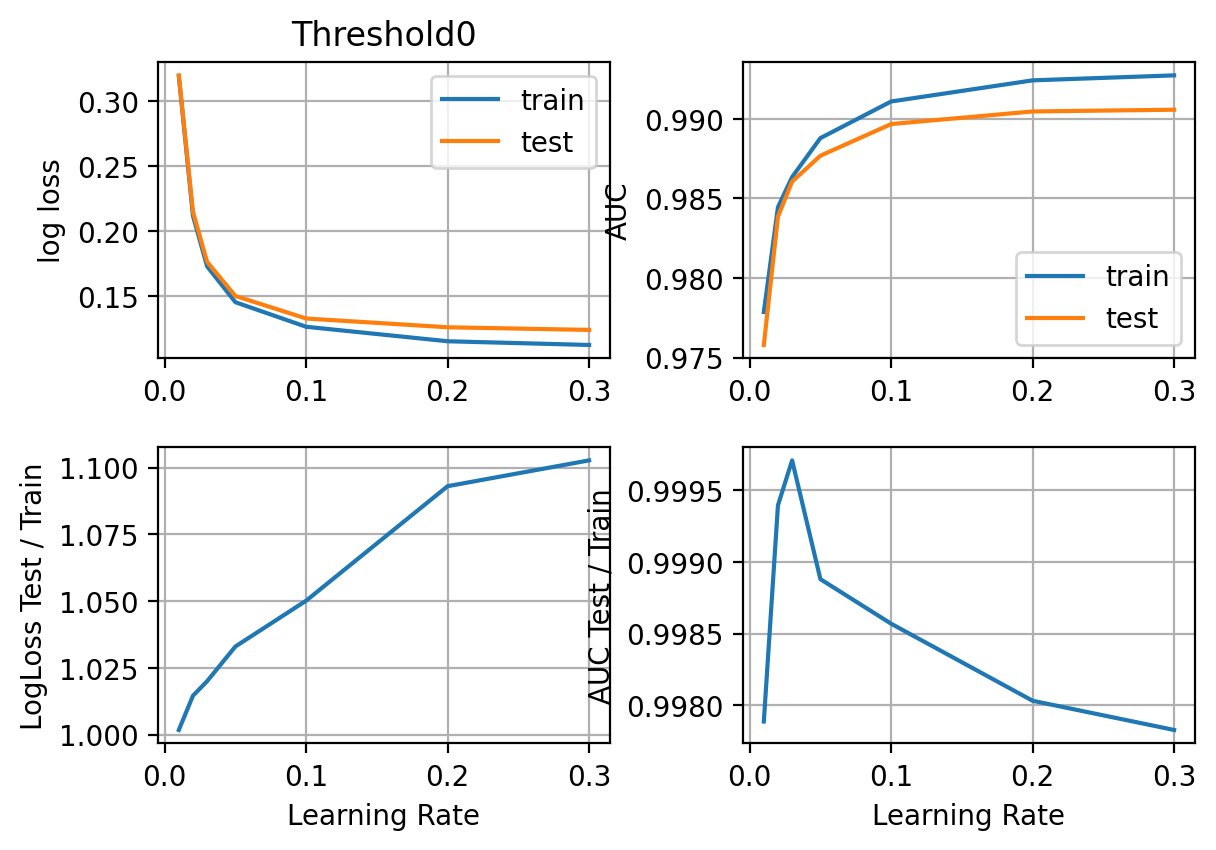

In [15]:
for name in learning_rates.keys():
    fig, axes = plt.subplots(2, 2, dpi=200)
    fig.tight_layout()
    axes[0,0].set_title(name)
    axes[0,0].plot(learning_rates[name], train_logloss_min_lr[name], label='train')
    axes[0,0].plot(learning_rates[name], test_logloss_min_lr[name], label='test')
    axes[0,0].legend()
    axes[0,0].set_ylabel('log loss')
    axes[0,0].grid()

    axes[0,1].plot(learning_rates[name], train_auc_max_lr[name], label='train')
    axes[0,1].plot(learning_rates[name], test_auc_max_lr[name], label='test')
    axes[0,1].legend()
    axes[0,1].set_ylabel('AUC')
    axes[0,1].grid()
    
    axes[1,0].plot(learning_rates[name], np.array(test_logloss_min_lr[name])/np.array(train_logloss_min_lr[name]))
    axes[1,0].set_ylabel('LogLoss Test / Train')
    axes[1,0].set_xlabel('Learning Rate')
    axes[1,0].grid()
    
    axes[1,1].plot(learning_rates[name], np.array(test_auc_max_lr[name])/np.array(train_auc_max_lr[name]))
    axes[1,1].set_ylabel('AUC Test / Train')
    axes[1,1].set_xlabel('Learning Rate')
    axes[1,1].grid()
    
    plt.show()

### Training with different tree depths

In [16]:
trained_models_depth = {}
stoppers_depth = {}
callbacks_depth = {}
params_depth = {}

# Turn to True in order to train for all the different FE algorithms
run_all_depth = False

# Tree depth values to be scanned
depths = [2,3,4,6,8,10]


for name, df in algos_dfs.items():
    if not run_all_depth and name!='Threshold0':
        continue
    print('==========================================')
    print('Trainings for', name)
    X_train, X_test, y_train, y_test = train_test_split(df[inputs], df[output], test_size=0.2, random_state=1234)
    weight_elec_train = y_train[y_train==0].shape[0]/y_train[y_train==1].shape[0]
    weight_elec_test = y_test[y_test==0].shape[0]/y_test[y_test==1].shape[0]
    print(" Electron size, train:", y_train[y_train==1].shape[0], "test:", y_test[y_test==1].shape[0])
    print(" PU size, train:", y_train[y_train==0].shape[0], "test:", y_test[y_test==0].shape[0])
    print(" Applying weight of", weight_elec_train, "to electrons to balance the training sample")
    print(" Applying weight of", weight_elec_test, "to electrons to balance the testing sample")
    print('==========================================')
    w_train = np.where(y_train==1, weight_elec_train, 1.)
    w_test = np.where(y_test==1, weight_elec_test, 1.)
    trained_models_depth[name] = []
    stoppers_depth[name] = []
    callbacks_depth[name] = []
    params_depth[name] = []
    for depth in depths:
        print(' > Training depth=', depth)
        param_cp = copy.deepcopy(params0)
        param_cp['max_depth'] = depth
        my_stopper = MyStopper()
        my_callback = MyCallback(my_stopper, my_adapter)
        model = xgb.XGBClassifier()
        model.set_params(**param_cp)
        trained_model = model.fit(X_train, y_train, 
                    sample_weight=w_train,
                    verbose=False, callbacks=[my_callback.callback],
                    eval_set=[(X_train,y_train), (X_test, y_test)],# 0=train, 1=test
                    sample_weight_eval_set=[w_train, w_test],
                    eval_metric=['auc','logloss'])
        params_depth[name].append(param_cp)
        trained_models_depth[name].append(trained_model)
        stoppers_depth[name].append(my_stopper)
        callbacks_depth[name].append(my_callback)

Trainings for Threshold0
 Electron size, train: 170962 test: 42749
 PU size, train: 4828 test: 1199
 Applying weight of 0.02824019372726103 to electrons to balance the training sample
 Applying weight of 0.028047439706191956 to electrons to balance the testing sample
 > Training depth= 2
 > Training depth= 3
 > Training depth= 4
 > Training depth= 6
 > Training depth= 8
 > Training depth= 10


In [17]:

depths = {}
test_logloss_min_depth = {}
train_logloss_min_depth = {}
test_auc_max_depth = {}
train_auc_max_depth = {}
for name in params_depth.keys():
    depths[name] = []
    test_logloss_min_depth[name] = []
    train_logloss_min_depth[name] = []
    test_auc_max_depth[name] = []
    train_auc_max_depth[name] = []
    for param,callback in zip(params_depth[name],callbacks_depth[name]):
        depths[name].append(param['max_depth'])
        # Extract the argmin on the test set and get the corresponding loss in the validation and test sets
        amin_loss = np.argmin(callback.eval_values['validation_1-logloss'])
        test_logloss_min_depth[name].append(callback.eval_values['validation_1-logloss'][amin_loss])
        train_logloss_min_depth[name].append(callback.eval_values['validation_0-logloss'][amin_loss])
        # Extract the argmax on the test set and get the corresponding AUC in the validation and test sets
        amax_auc = np.argmax(callback.eval_values['validation_1-auc'])
        test_auc_max_depth[name].append(callback.eval_values['validation_1-auc'][amax_auc])
        train_auc_max_depth[name].append(callback.eval_values['validation_0-auc'][amax_auc])
    

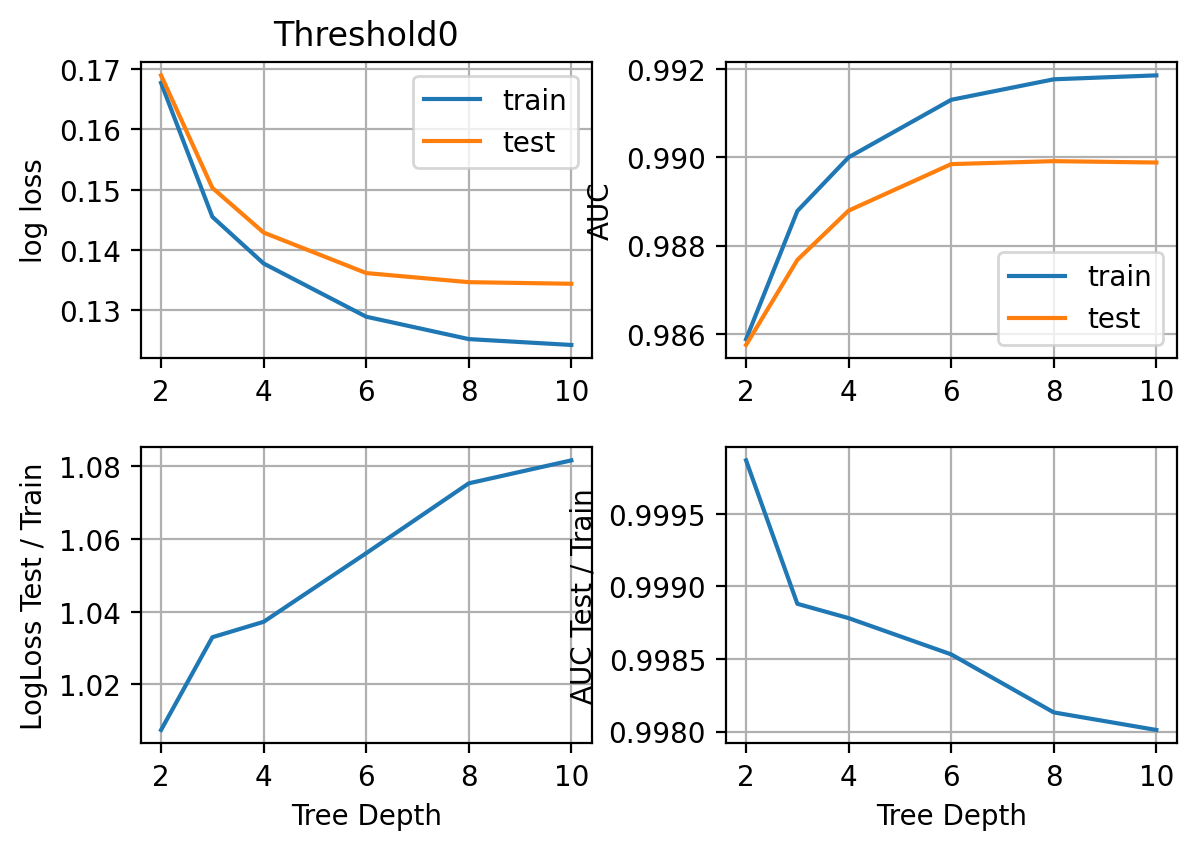

In [18]:
for name in depths.keys():
    fig, axes = plt.subplots(2, 2, dpi=200)
    fig.tight_layout()
    axes[0,0].set_title(name)
    axes[0,0].plot(depths[name], train_logloss_min_depth[name], label='train')
    axes[0,0].plot(depths[name], test_logloss_min_depth[name], label='test')
    axes[0,0].legend()
    axes[0,0].set_ylabel('log loss')
    axes[0,0].grid()

    axes[0,1].plot(depths[name], train_auc_max_depth[name], label='train')
    axes[0,1].plot(depths[name], test_auc_max_depth[name], label='test')
    axes[0,1].legend()
    axes[0,1].set_ylabel('AUC')
    axes[0,1].grid()
    
    axes[1,0].plot(depths[name], np.array(test_logloss_min_depth[name])/np.array(train_logloss_min_depth[name]))
    axes[1,0].set_ylabel('LogLoss Test / Train')
    axes[1,0].set_xlabel('Tree Depth')
    axes[1,0].grid()
    
    axes[1,1].plot(depths[name], np.array(test_auc_max_depth[name])/np.array(train_auc_max_depth[name]))
    axes[1,1].set_ylabel('AUC Test / Train')
    axes[1,1].set_xlabel('Tree Depth')
    axes[1,1].grid()
    
    plt.show() 

### Training with selected regularization, learning rate and tree depth

In [19]:
param = copy.deepcopy(params0)
param['learning_rate'] = 0.05 # initial learning rate
param['max_depth'] = 4  # maximum depth of a tree
param['n_estimators'] = 200
param['alpha'] = 10 # L1 regularization
param['lambda'] = 10 # L2 regularization


trained_models = {}
stoppers = {}
callbacks = {}
params = {}
for name, df in algos_dfs.items():
    print('==========================================')
    print('Trainings for', name)
    X_train, X_test, y_train, y_test = train_test_split(df[inputs], df[output], test_size=0.2, random_state=1234)
    weight_elec_train = y_train[y_train==0].shape[0]/y_train[y_train==1].shape[0]
    weight_elec_test = y_test[y_test==0].shape[0]/y_test[y_test==1].shape[0]
    print(" Electron size, train:", y_train[y_train==1].shape[0], "test:", y_test[y_test==1].shape[0])
    print(" PU size, train:", y_train[y_train==0].shape[0], "test:", y_test[y_test==0].shape[0])
    print(" Applying weight of", weight_elec_train, "to electrons to balance the training sample")
    print(" Applying weight of", weight_elec_test, "to electrons to balance the testing sample")
    print('==========================================')
    w_train = np.where(y_train==1, weight_elec_train, 1.)
    w_test = np.where(y_test==1, weight_elec_test, 1.)
    param_cp = copy.deepcopy(param)
    print(param_cp)
    my_stopper = MyStopper()
    my_callback = MyCallback(my_stopper, my_adapter)
    model = xgb.XGBClassifier()
    model.set_params(**param_cp)
    trained_model = model.fit(X_train, y_train, 
                sample_weight=w_train,
                verbose=False, callbacks=[my_callback.callback],
                eval_set=[(X_train,y_train), (X_test, y_test)],
                sample_weight_eval_set=[w_train, w_test],
                eval_metric=['auc','logloss'])
    params[name] = param_cp
    trained_models[name] = trained_model
    stoppers[name] = my_stopper
    callbacks[name] = my_callback


Trainings for Threshold0
 Electron size, train: 170962 test: 42749
 PU size, train: 4828 test: 1199
 Applying weight of 0.02824019372726103 to electrons to balance the training sample
 Applying weight of 0.028047439706191956 to electrons to balance the testing sample
{'nthread': 5, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 200, 'alpha': 10, 'lambda': 10, 'objective': 'binary:logistic'}
Trainings for Threshold
 Electron size, train: 170967 test: 42744
 PU size, train: 3980 test: 993
 Applying weight of 0.02327934630659718 to electrons to balance the training sample
 Applying weight of 0.02323133071308254 to electrons to balance the testing sample
{'nthread': 5, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 200, 'alpha': 10, 'lambda': 10, 'objective': 'binary:logistic'}
Trainings for Mixedbcstc
 Electron size, train: 170985 test: 42722
 PU size, train: 4822 test: 1230
 Applying wei

Compare test and train losses and AUCs as a function of the number of boosting steps for all the different FE algorithms.

Threshold0
Min logloss =  0.128319
Max AUC =  0.990194


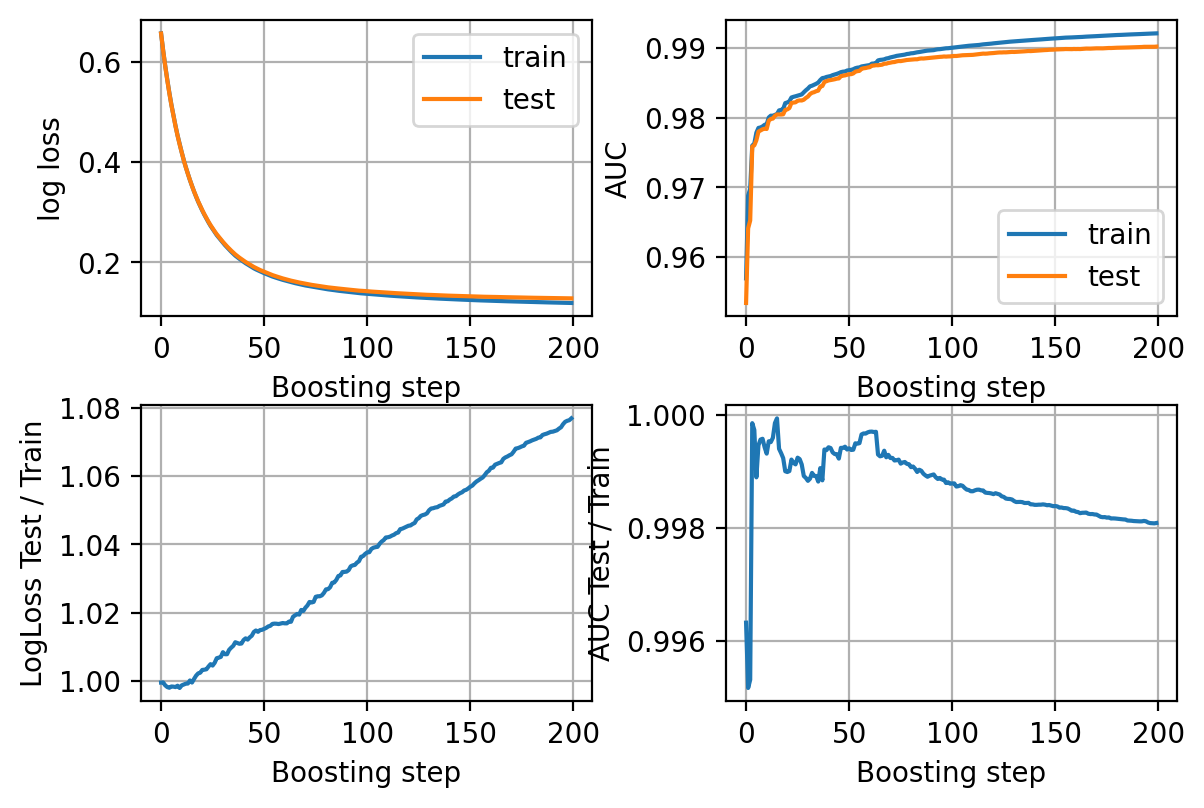

Threshold
Min logloss =  0.134631
Max AUC =  0.989322


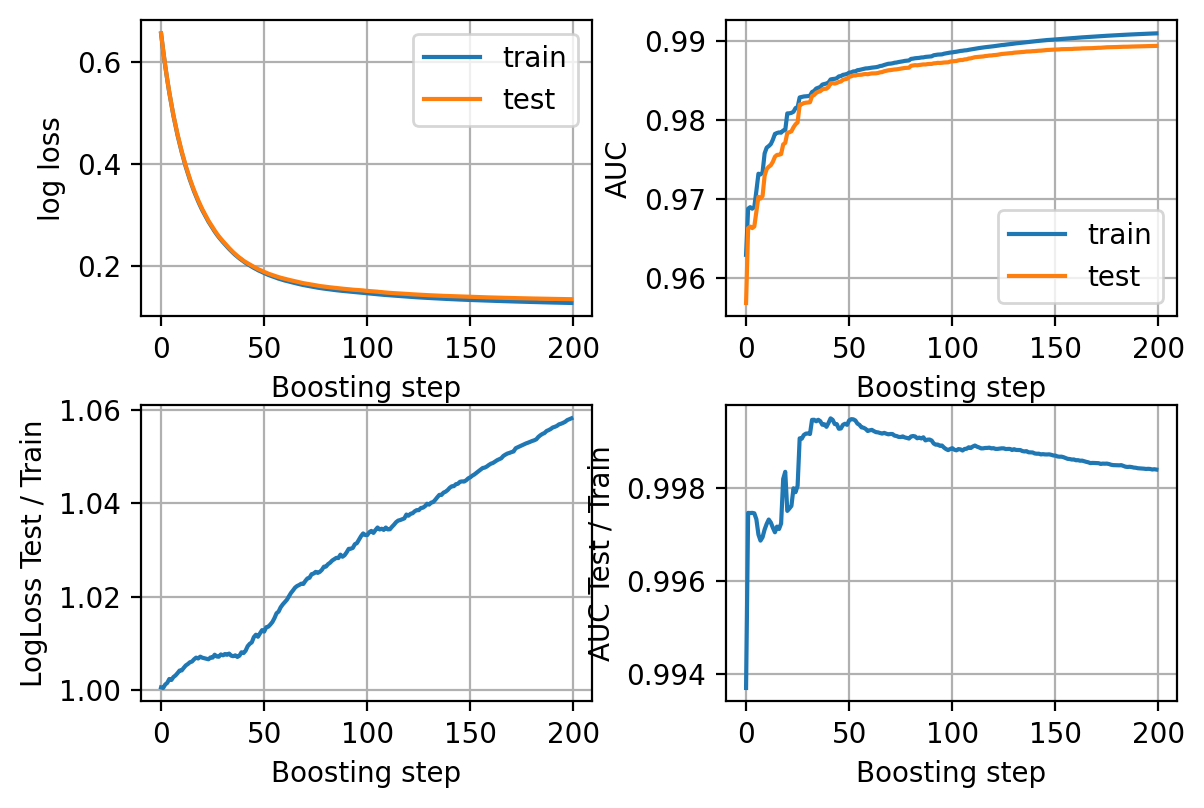

Mixedbcstc
Min logloss =  0.138569
Max AUC =  0.988636


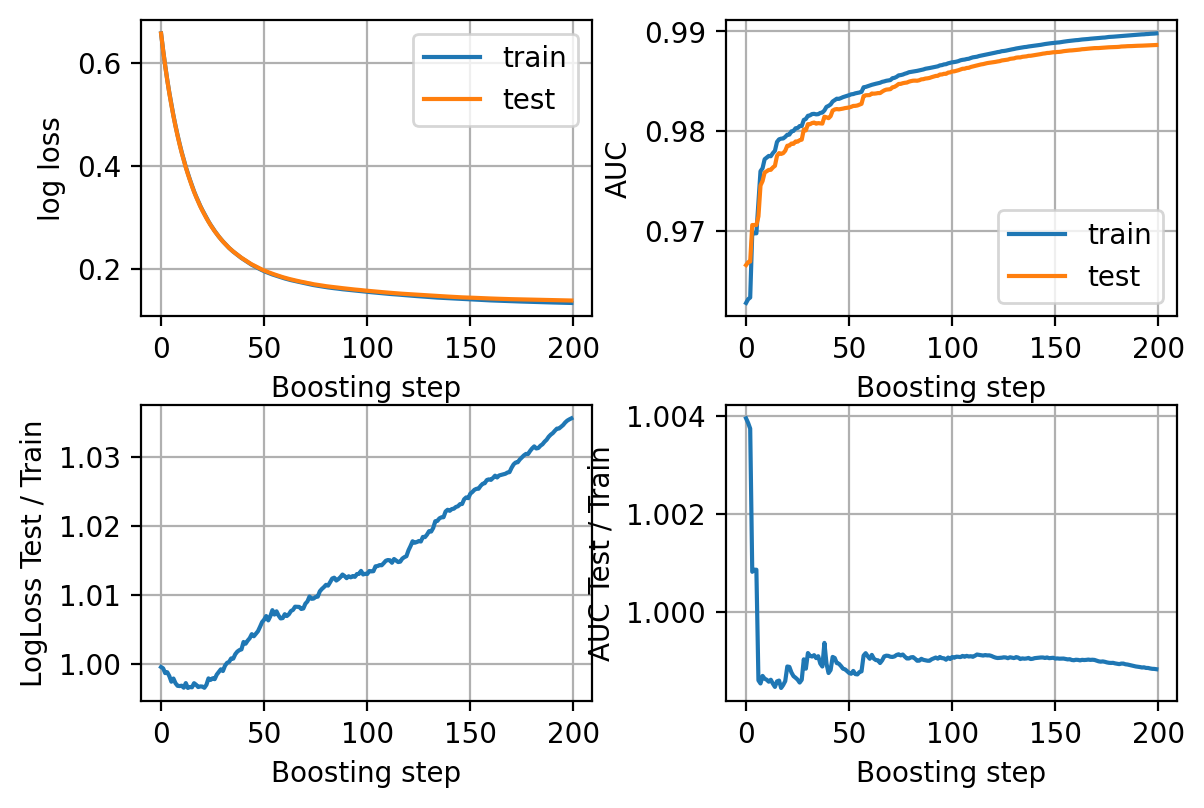

AutoEncoderTelescopeMSE
Min logloss =  0.210157
Max AUC =  0.975247


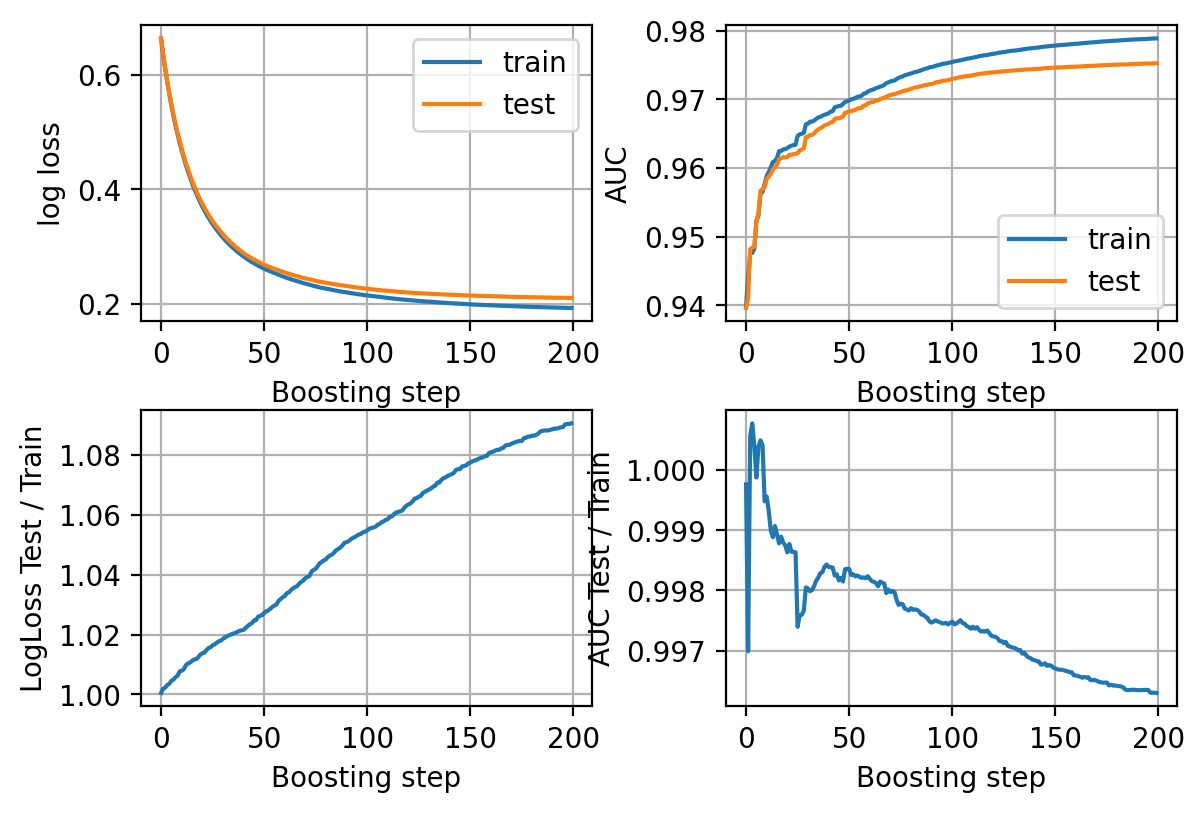

AutoEncoderStride
Min logloss =  0.196547
Max AUC =  0.978469


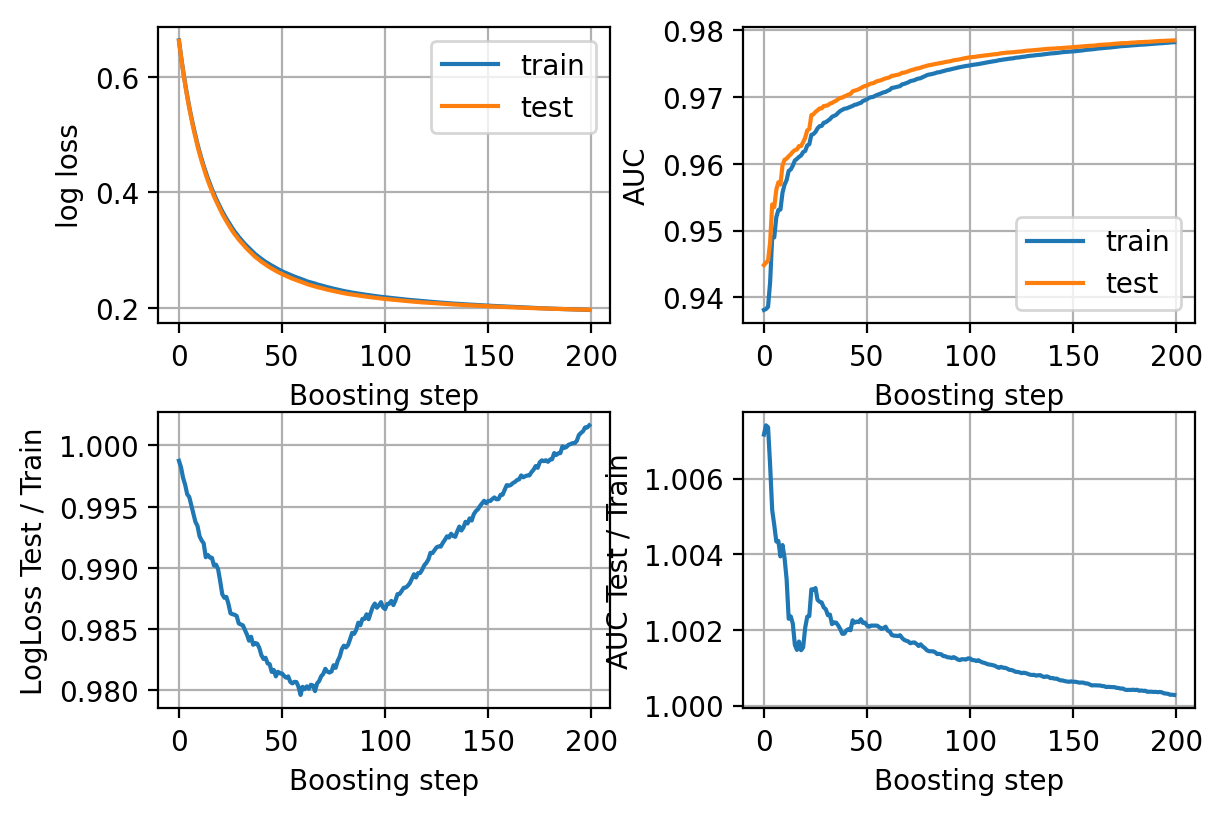

AutoEncoderQKerasTTbar
Min logloss =  0.224662
Max AUC =  0.971187


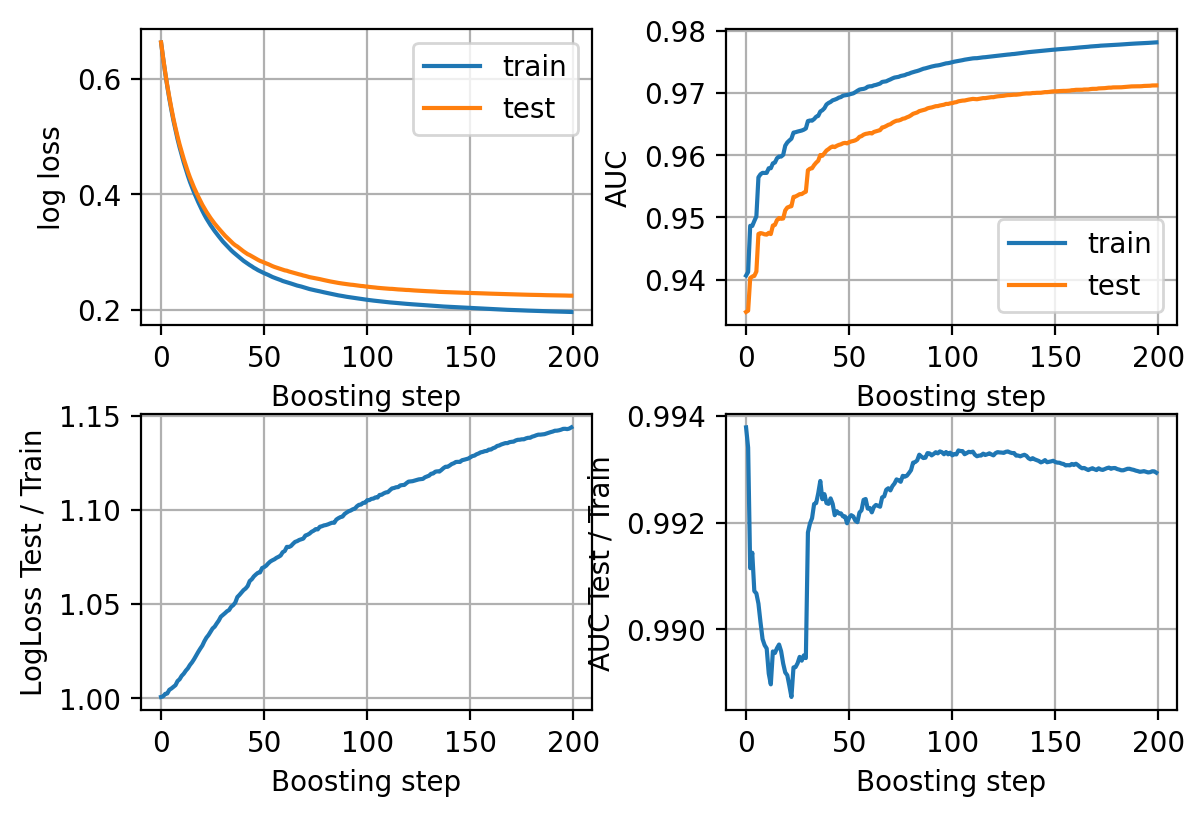

AutoEncoderQKerasEle
Min logloss =  0.183753
Max AUC =  0.980637


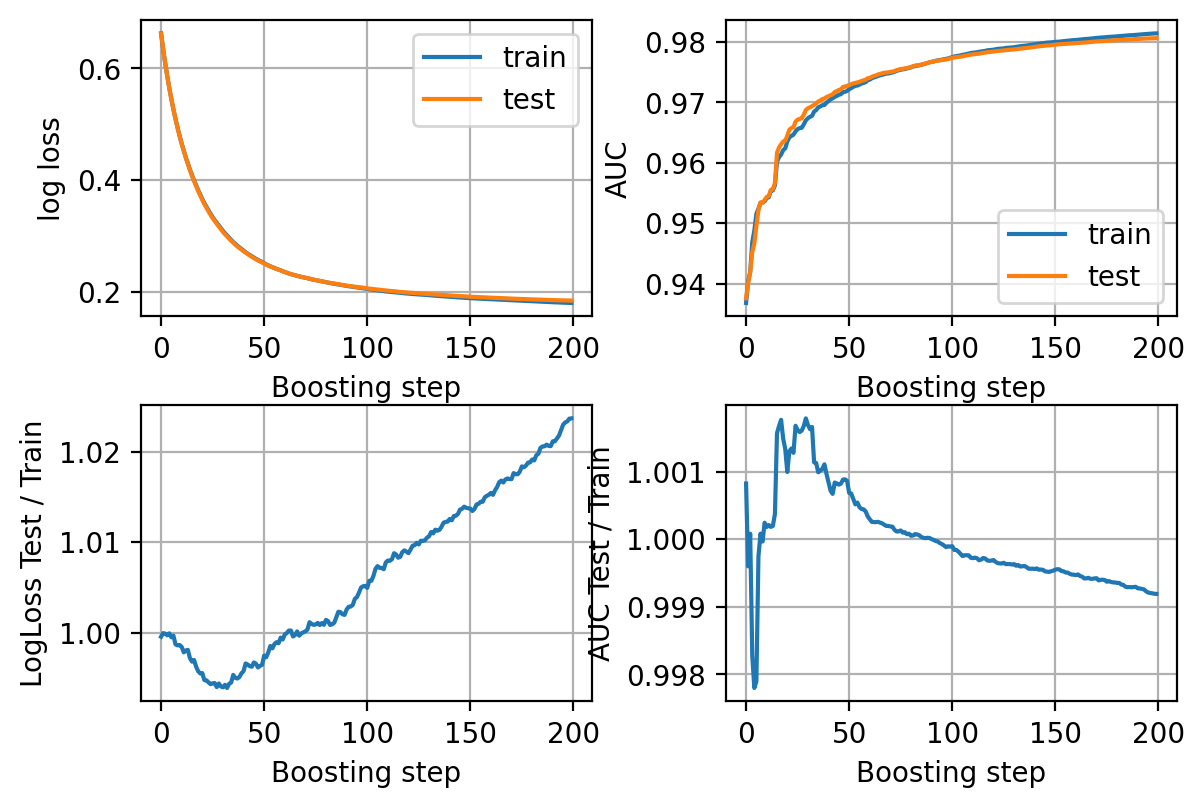

In [20]:
for name,callback in callbacks.items():
    print(name)
    test_logloss = callback.eval_values['validation_1-logloss']
    train_logloss = callback.eval_values['validation_0-logloss']
    test_auc = callback.eval_values['validation_1-auc']
    train_auc = callback.eval_values['validation_0-auc']
    print('Min logloss = ', np.min(test_logloss))
    print('Max AUC = ', np.max(test_auc))
    fig, axes = plt.subplots(2, 2, dpi=200)
    fig.tight_layout()
    axes[0,0].plot(callback.eval_values['validation_0-logloss'], label='train')
    axes[0,0].plot(callback.eval_values['validation_1-logloss'], label='test')
    axes[0,0].legend()
    axes[0,0].set_ylabel('log loss')
    axes[0,0].set_xlabel('Boosting step')
    axes[0,0].grid()

    axes[0,1].plot(callback.eval_values['validation_0-auc'], label='train')
    axes[0,1].plot(callback.eval_values['validation_1-auc'], label='test')
    axes[0,1].legend()
    axes[0,1].set_ylabel('AUC')
    axes[0,1].set_xlabel('Boosting step')
    axes[0,1].grid()
    
    axes[1,0].plot(np.array(callback.eval_values['validation_1-logloss'])/np.array(callback.eval_values['validation_0-logloss']))
    axes[1,0].set_ylabel('LogLoss Test / Train')
    axes[1,0].set_xlabel('Boosting step')
    axes[1,0].grid()
    
    axes[1,1].plot(np.array(callback.eval_values['validation_1-auc']/np.array(callback.eval_values['validation_0-auc'])))
    axes[1,1].set_ylabel('AUC Test / Train')
    axes[1,1].set_xlabel('Boosting step')
    axes[1,1].grid()

    plt.show()

### Retraining with limited number of boosting steps

In [21]:
param_final = copy.deepcopy(params0)
param_final['learning_rate'] = 0.05 # initial learning rate
param_final['max_depth'] = 4  # maximum depth of a tree
param_final['lambda'] = 10 # L2 regularization
param_final['alpha'] = 10 # L1 regularization
param_final['n_estimators'] = 50

trained_models_final = {}
stoppers_final = {}
callbacks_final = {}
params_final = {}
for name, df in algos_dfs.items():
    print('==========================================')
    print('Trainings for', name)
    X_train, X_test, y_train, y_test = train_test_split(df[inputs], df[output], test_size=0.2, random_state=1234)
    # Keep track of the train and test samples
    df['train'] = 0
    df.loc[X_train.index, 'train'] = 1
    weight_elec_train = y_train[y_train==0].shape[0]/y_train[y_train==1].shape[0]
    weight_elec_test = y_test[y_test==0].shape[0]/y_test[y_test==1].shape[0]
    print(" Electron size, train:", y_train[y_train==1].shape[0], "test:", y_test[y_test==1].shape[0])
    print(" PU size, train:", y_train[y_train==0].shape[0], "test:", y_test[y_test==0].shape[0])
    print(" Applying weight of", weight_elec_train, "to electrons to balance the training sample")
    print(" Applying weight of", weight_elec_test, "to electrons to balance the testing sample")
    print('==========================================')
    w_train = np.where(y_train==1, weight_elec_train, 1.)
    w_test = np.where(y_test==1, weight_elec_test, 1.)
    param_cp = copy.deepcopy(param_final)
    print(param_cp)
    my_stopper = MyStopper()
    my_callback = MyCallback(my_stopper, my_adapter)
    model = xgb.XGBClassifier()
    model.set_params(**param_cp)
    trained_model = model.fit(X_train, y_train, 
                sample_weight=w_train,
                verbose=False, callbacks=[my_callback.callback],
                eval_set=[(X_train,y_train), (X_test, y_test)],
                sample_weight_eval_set=[w_train, w_test],
                eval_metric=['auc','logloss'])
    params_final[name] = param_cp
    trained_models_final[name] = trained_model
    stoppers_final[name] = my_stopper
    callbacks_final[name] = my_callback

Trainings for Threshold0
 Electron size, train: 170962 test: 42749
 PU size, train: 4828 test: 1199
 Applying weight of 0.02824019372726103 to electrons to balance the training sample
 Applying weight of 0.028047439706191956 to electrons to balance the testing sample
{'nthread': 5, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 50, 'alpha': 10, 'lambda': 10, 'objective': 'binary:logistic'}
Trainings for Threshold
 Electron size, train: 170967 test: 42744
 PU size, train: 3980 test: 993
 Applying weight of 0.02327934630659718 to electrons to balance the training sample
 Applying weight of 0.02323133071308254 to electrons to balance the testing sample
{'nthread': 5, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 50, 'alpha': 10, 'lambda': 10, 'objective': 'binary:logistic'}
Trainings for Mixedbcstc
 Electron size, train: 170985 test: 42722
 PU size, train: 4822 test: 1230
 Applying weigh

## Final overtraining checks
Extract the cut on the BDT output (defined as the estimated electron probability) for a 99% efficiency on electrons.

In [22]:
cuts_99 = {}
for name, df in algos_dfs.items():
    model = trained_models_final[name]
    df['bdt_output'] = model.predict_proba(df[inputs])[:,1]
    cut_99 = np.quantile(df.query('genpart_pid==1 & train==1')['bdt_output'], q=0.01)
    cuts_99[name] = cut_99
    print(name)
    print('> BDT output cut for 99% signal efficiency =', cut_99)
    

Threshold0
> BDT output cut for 99% signal efficiency = 0.19749946892261505
Threshold
> BDT output cut for 99% signal efficiency = 0.21198147535324097
Mixedbcstc
> BDT output cut for 99% signal efficiency = 0.18226654827594757
AutoEncoderTelescopeMSE
> BDT output cut for 99% signal efficiency = 0.16126342073082925
AutoEncoderStride
> BDT output cut for 99% signal efficiency = 0.17712271213531494
AutoEncoderQKerasTTbar
> BDT output cut for 99% signal efficiency = 0.1633698433637619
AutoEncoderQKerasEle
> BDT output cut for 99% signal efficiency = 0.15476907789707184


Check the BDT output distributions in the test and train samples, for electrons and PU clusters

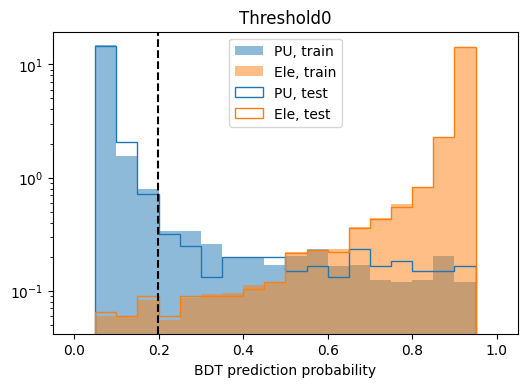

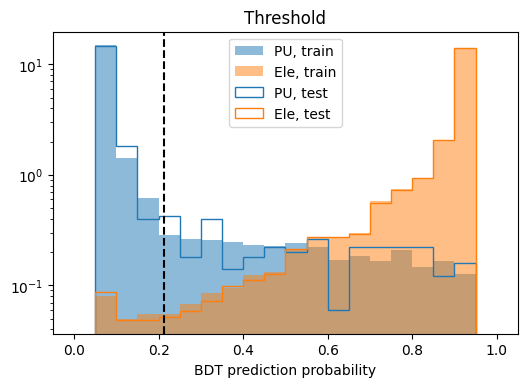

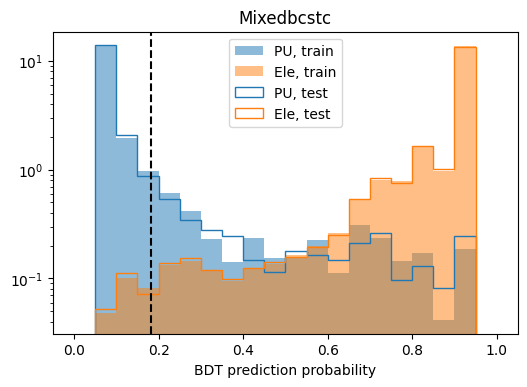

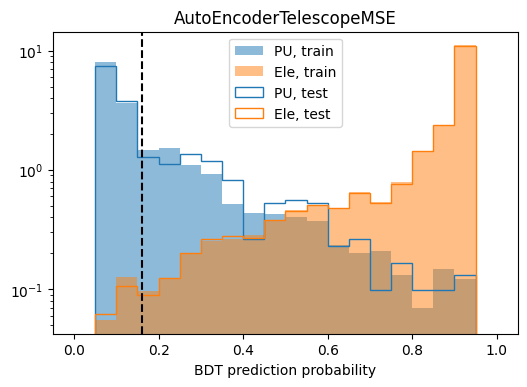

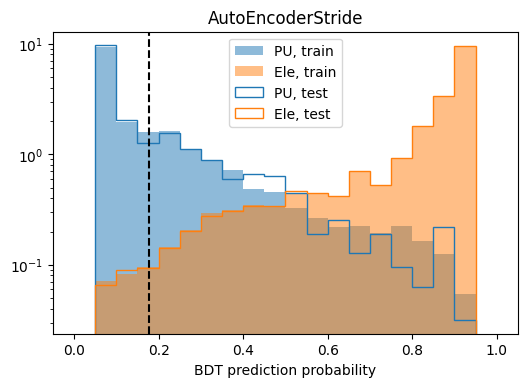

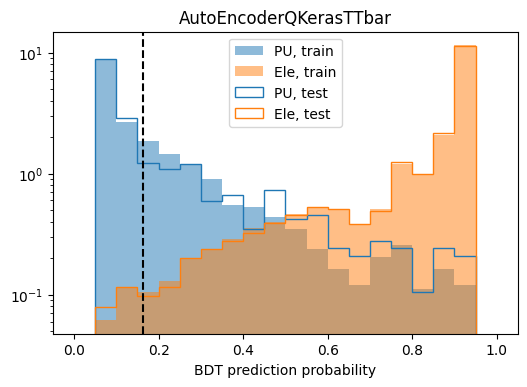

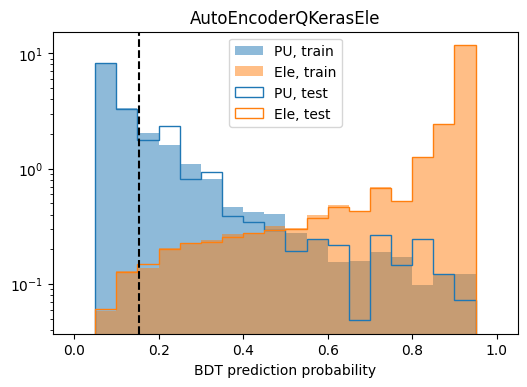

In [23]:
for name, df in algos_dfs.items():
    plt.figure(dpi=100)
    plt.hist(df.query('genpart_pid==0 & train==1')['bdt_output'], density=True, bins=np.arange(0, 1.05, 0.05), histtype='bar', label='PU, train', color='tab:blue', alpha=0.5)
    plt.hist(df.query('genpart_pid==1 & train==1')['bdt_output'], density=True, bins=np.arange(0, 1.05, 0.05), histtype='bar', label='Ele, train', color='tab:orange', alpha=0.5)
    plt.hist(df.query('genpart_pid==0 & train==0')['bdt_output'], density=True, bins=np.arange(0, 1.05, 0.05), histtype='step', label='PU, test', color='tab:blue')
    plt.hist(df.query('genpart_pid==1 & train==0')['bdt_output'], density=True, bins=np.arange(0, 1.05, 0.05), histtype='step', label='Ele, test', color='tab:orange')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('BDT prediction probability')
    plt.axvline(x = cuts_99[name], color = 'black', ls='--')
    plt.title(name)
    plt.show()


Extract electrons and PU into separate dataframes and bin the sample in pT (generated pT for electrons and corrected cluster pT for PU).

In [24]:
dfs_ele = {}
dfs_pu = {}
for name,df in algos_dfs.items():
    df_ele = df.query('genpart_pid==1')
    df_pu = df.query('genpart_pid==0')
    df_ele['genpart_pt_bin'] = ((df_ele.genpart_pt - 15)/10).astype('int32')
    df_pu['cl3d_pt_corr_bin'] = ((df_pu.cl3d_pt_corr - 20)/20).astype('int32')
    dfs_ele[name] = df_ele
    dfs_pu[name] = df_pu

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Define functions to compute efficiencies and their errors (using Clopper-Pearson $1\sigma$ interval)

In [25]:
#clopper pearson
def error(total, passed, conf_level=0.683):
    alpha=(1-conf_level)/2.
    lo = scipy.stats.beta.ppf(alpha, passed, total-passed+1) if passed!=0 else 0.
    hi = scipy.stats.beta.ppf(1 - alpha, passed+1, total-passed) if passed!=total else 1.
    return lo, hi

def efficiency(group, cut):
    tot = group.shape[0]
    sel = group[group.bdt_output > cut].shape[0]
    lo, hi = error(tot, sel)
    eff = sel/tot
    return pd.Series((eff, eff-lo, hi-eff))

Compute efficiencies vs pT for electrons and PU in the test and train samples

In [26]:
signaleff_vs_pt_train = {}
signaleff_vs_pt_test = {}
for name,df in dfs_ele.items():
    df_train = df.query('train==1')
    df_test = df.query('train==0')
    # Efficiency train sample
    signaleff_vs_pt_train[name] = df_train.groupby('genpart_pt_bin').mean()
    eff = df_train.groupby('genpart_pt_bin').apply(lambda x : efficiency(x, cuts_99[name]))
    eff.columns = ['efficiency', 'eff_errdo', 'eff_errup']
    signaleff_vs_pt_train[name] = signaleff_vs_pt_train[name].merge(eff, left_on='genpart_pt_bin', right_on='genpart_pt_bin')[['genpart_pt', 'efficiency', 'eff_errdo', 'eff_errup']]
    # Efficiency test sample
    signaleff_vs_pt_test[name] = df_test.groupby('genpart_pt_bin').mean()
    eff = df_test.groupby('genpart_pt_bin').apply(lambda x : efficiency(x, cuts_99[name]))
    eff.columns = ['efficiency', 'eff_errdo', 'eff_errup']
    signaleff_vs_pt_test[name] = signaleff_vs_pt_test[name].merge(eff, left_on='genpart_pt_bin', right_on='genpart_pt_bin')[['genpart_pt', 'efficiency', 'eff_errdo', 'eff_errup']]
    
pueff_vs_pt_train = {}
pueff_vs_pt_test = {}
for name,df in dfs_pu.items():
    df_train = df.query('train==1')
    df_test = df.query('train==0')
    # Efficiency train sample
    pueff_vs_pt_train[name] = df_train.groupby('cl3d_pt_corr_bin').mean()
    eff = df_train.groupby('cl3d_pt_corr_bin').apply(lambda x : efficiency(x, cuts_99[name]))
    eff.columns = ['efficiency', 'eff_errdo', 'eff_errup']
    pueff_vs_pt_train[name] = pueff_vs_pt_train[name].merge(eff, left_on='cl3d_pt_corr_bin', right_on='cl3d_pt_corr_bin')[['cl3d_pt_corr', 'efficiency', 'eff_errdo', 'eff_errup']]
    # Efficiency test sample
    pueff_vs_pt_test[name] = df_test.groupby('cl3d_pt_corr_bin').mean()
    eff = df_test.groupby('cl3d_pt_corr_bin').apply(lambda x : efficiency(x, cuts_99[name]))
    eff.columns = ['efficiency', 'eff_errdo', 'eff_errup']
    pueff_vs_pt_test[name] = pueff_vs_pt_test[name].merge(eff, left_on='cl3d_pt_corr_bin', right_on='cl3d_pt_corr_bin')[['cl3d_pt_corr', 'efficiency', 'eff_errdo', 'eff_errup']]

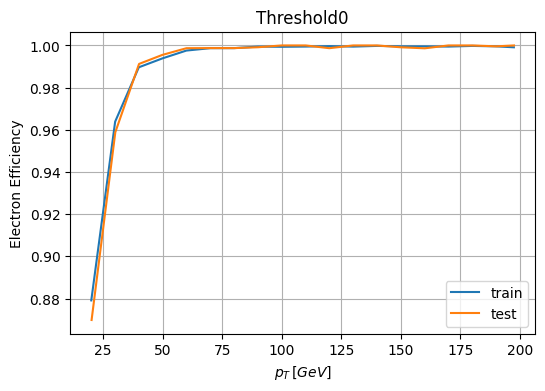

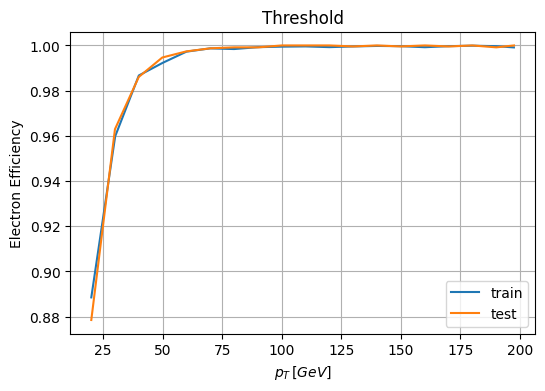

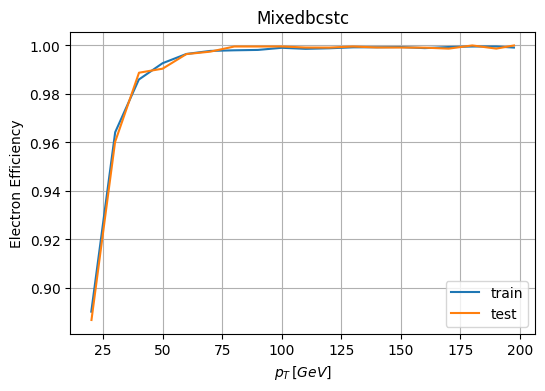

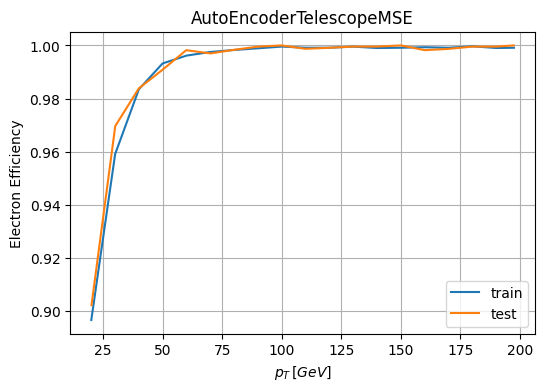

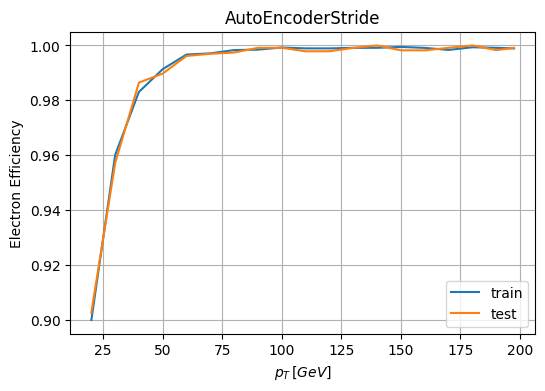

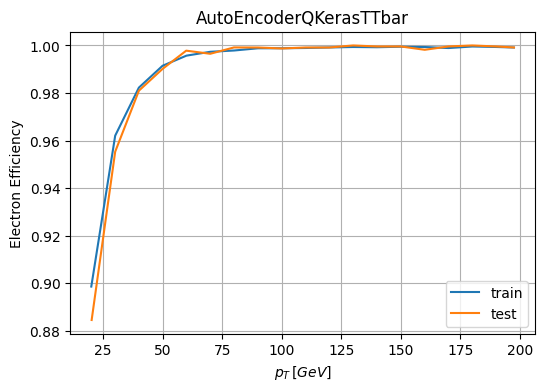

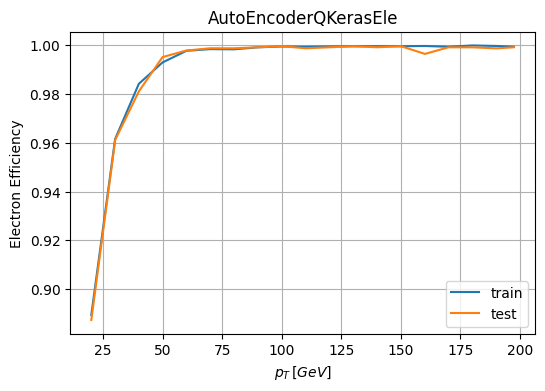

In [27]:
for name, df_train in signaleff_vs_pt_train.items():
    df_test = signaleff_vs_pt_test[name]
    plt.figure(dpi=100)
    plt.plot(df_train.genpart_pt, df_train.efficiency, label='train')
    plt.plot(df_test.genpart_pt, df_test.efficiency, label='test')
    plt.xlabel(r'$p_{T}\,[GeV]$')
    plt.ylabel('Electron Efficiency')
    plt.grid()
    plt.title(name)
    plt.legend()
    plt.show()

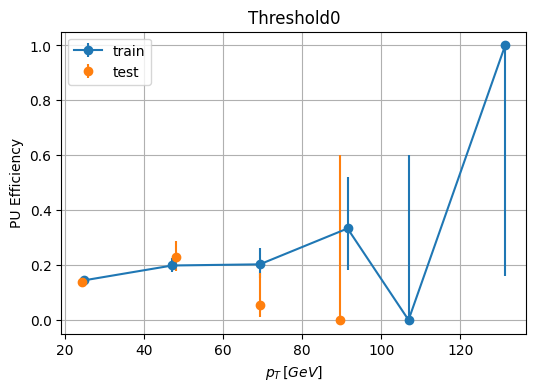

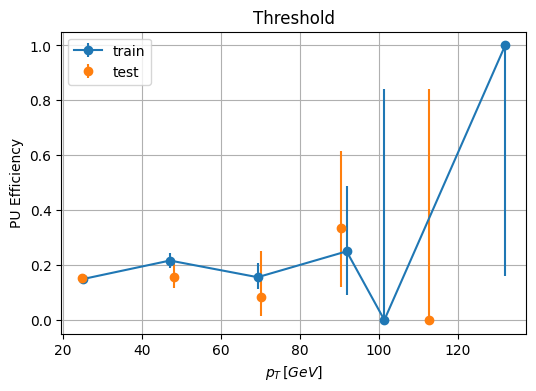

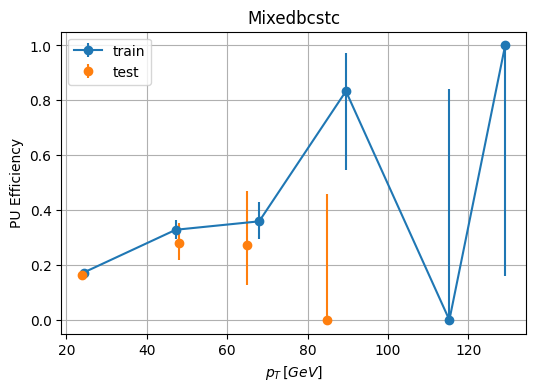

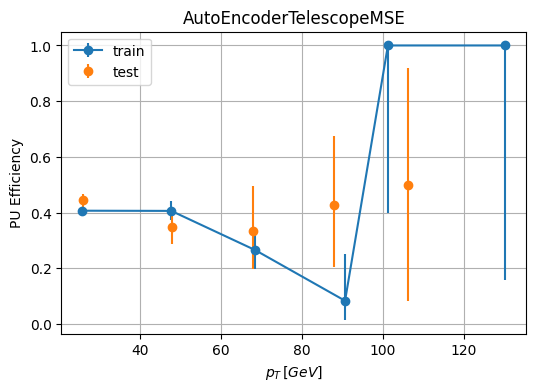

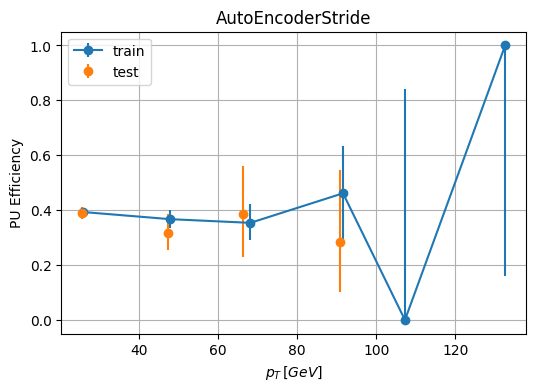

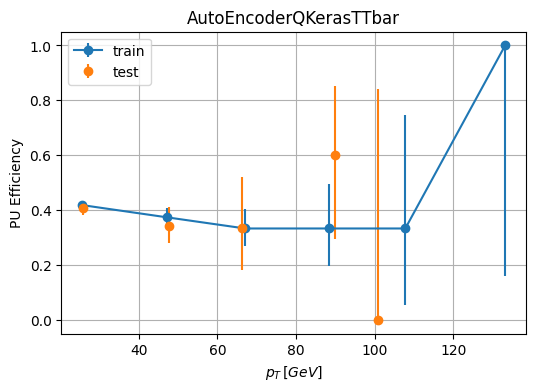

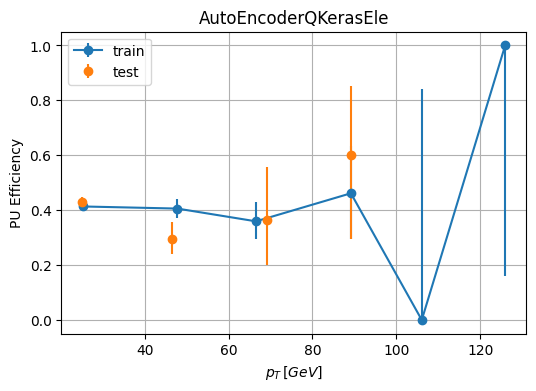

In [28]:
for name, df_train in pueff_vs_pt_train.items():
    df_test = pueff_vs_pt_test[name]
    plt.figure(dpi=100)
    plt.errorbar(df_train.cl3d_pt_corr, df_train.efficiency, yerr=df_train[['eff_errdo', 'eff_errup']].to_numpy().T,
                 label='train', marker='o', ls='-')
    plt.errorbar(df_test.cl3d_pt_corr, df_test.efficiency, yerr=df_test[['eff_errdo', 'eff_errup']].to_numpy().T,
                 label='test', marker='o', ls='')
    plt.xlabel(r'$p_{T}\,[GeV]$')
    plt.ylabel('PU Efficiency')
    plt.grid()
    plt.title(name)
    plt.legend()
    plt.show()